# Clasificación de imágenes de muestras geológicas mediante la técnica de aprendizaje por transferencia aplicada en resNet50

# Resumen
Este proyecto se centra en aplicar la técnica de aprendizaje por transferencia utilizando ResNet50 para clasificar muestras geológicas mediante imágenes. El objetivo principal es evaluar la efectividad y precisión de la red neuronal previamente entrenada en la identificación de diferentes tipos de rocas, minerales y materiales geológicos. El estudio busca aportar conclusiones relevantes sobre la aplicación de la inteligencia artificial en geología y ciencias de la tierra.

# 1. Introducción
La inteligencia artificial se ha aplicado ampliamente en varias áreas, incluida la geología. Clasificar imágenes de muestras geológicas es una tarea importante para identificar y caracterizar diferentes tipos de rocas, minerales y otros materiales geológicos. Sin embargo, esta tarea puede resultar un desafío debido a la amplia variedad de características y texturas presentes en las imágenes geológicas.

Una técnica eficiente para la clasificación de imágenes es el uso del aprendizaje por transferencia, que consiste en utilizar una red neuronal ya entrenada previamente sobre una gran cantidad de datos y adaptarla a una tarea específica. ResNet50 es una red neuronal profunda que ha logrado excelentes resultados en tareas generales de clasificación de imágenes.

En esta monografía, se presentará un estudio sobre la aplicación del aprendizaje por transferencia utilizando ResNet50 para clasificar imágenes de muestras geológicas. Se describirán los pasos de preprocesamiento de datos, entrenamiento y prueba de la red neuronal, además del análisis de los resultados obtenidos. Se discutirá en detalle la importancia de elegir los parámetros de entrenamiento y evaluar el rendimiento de la red.

Finalmente, se presentarán conclusiones sobre la efectividad de la técnica de aprendizaje por transferencia utilizando ResNet50 para clasificar imágenes de muestras geológicas, así como las posibilidades de aplicación en otras áreas de la geología y las ciencias de la tierra.

# 2. Modelado
En primer lugar, fue necesario preparar el conjunto de datos de muestras geológicas, provenientes del repositorio de similitud de imágenes geológicas de Kaggle, para alimentar la red neuronal.

link:

https://www.kaggle.com/datasets/tanyadayanand/geological-image-similarity

Se utilizó una utilidad de procesamiento de datos de Keras llamada "image_dataset_from_directory". Esta herramienta toma las imágenes del directorio, las organiza por carpetas (que representan clases) y cambia el tamaño de las imágenes. Genera tensores con tamaños de lote específicos listos para entrenamiento y validación.

Las 29998 imágenes de muestras geológicas están separadas en 6 clases, cada una en su propia carpeta:

* Andesita
* Gneis
* Mármol
* Cuarcita
* riolita
* Esquisto

In [ ]:
!rm -r /content/geological_similarity

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import zipfile
import os

# Path to the zip file
zip_file_path = './geological_similarity.zip'

# Directory where the contents will be extracted
extract_dir = './'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
# Tamaño de las imágenes
img_height, img_width = 224, 224
batch_size = 32
data_directory='./geological_similarity'


In [ ]:
train_ds = image_dataset_from_directory(
    seed=77,
    directory=data_directory,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='training',
    label_mode ='categorical'
    )

Found 29998 files belonging to 6 classes.
Using 23999 files for training.


Utilizando la misma herramienta, se creó el conjunto de datos de validación.

In [ ]:
validation_ds = image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=77,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode ='categorical'
    )

Found 29998 files belonging to 6 classes.
Using 5999 files for validation.


# Funcionalidades
Se crearon algunas funciones que ayudan a mostrar las imágenes del conjunto de datos y su respectiva clase.

In [ ]:
import matplotlib.pyplot as plt
import os


In [ ]:
classnames=[]
for root, dirs, files in os.walk(data_directory, topdown=False):
   classnames=[name for name in dirs]

In [ ]:
def cname(cat,classnames):
  index = np.argmax(cat)
  return classnames[index]

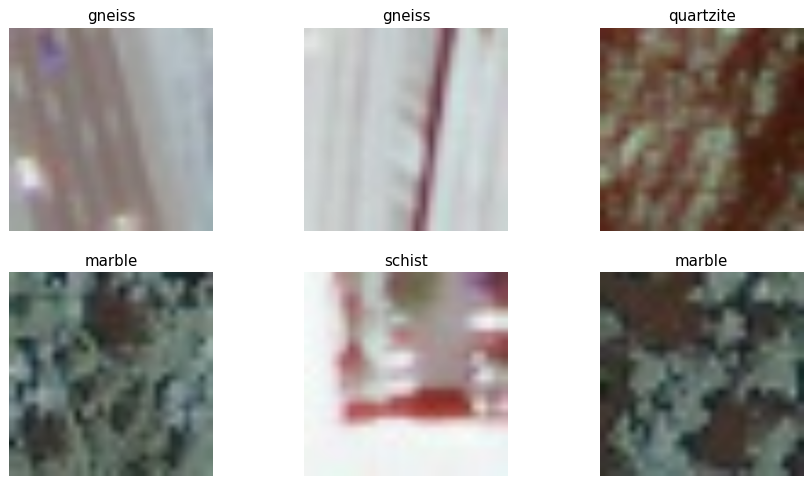

In [ ]:
def showtest(dataset,classnames=['none','none','none','none','none']):
  plt.figure(figsize=(12, 10),dpi=90)

  for images, labels in dataset.take(1):
    for var in range(6):
      ax = plt.subplot(3, 3, var + 1)
      plt.imshow(images[var].numpy().astype("uint8"))
      plt.title(cname(labels[var].numpy().astype("int32"),classnames) )
      plt.axis("off")

showtest(train_ds,classnames)

# Configuración del modelo
La red neuronal se basó en Resnet50 utilizando la técnica de aprendizaje por transferencia. Para hacer esto, utilizamos las bibliotecas tensorflow y keras para descargar el modelo base.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

In [ ]:
pretrained_model_for_demo= ResNet50(include_top=False, input_shape=(img_height, img_width,3),pooling='avg',classes=len(classnames),weights='imagenet')

In [ ]:
for each_layer in pretrained_model_for_demo.layers:
  each_layer.trainable=False
model = Sequential()
model.add(pretrained_model_for_demo)

El modelo se crea configurando resNet50 ingresando los tamaños de imagen y usando los pesos de imagenet.

En este caso, se agregaron una capa de 1024 neuronas densas y una capa de salida Danse de 6 neuronas, cada una de las cuales representa una clase de roca.

In [ ]:
from tensorflow.keras.layers import Flatten,Dense

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(classnames), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.build([None, img_height, img_width,3])
# model.build(input_shape=(img_height, img_width,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 25692038 (98.01 MB)
Trainable params: 2104326 (8.03 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


# Entrenamiento
Después de configurar la red, es posible realizar entrenamiento utilizando el conjunto de datos de muestras geológicas. Durante la capacitación, es importante monitorear las métricas de rendimiento de la red, como la precisión y la pérdida. Para esto se utilizaron los callbacks EarlyStopping y ReduceLROnPlateau para detener el entrenamiento cuando hubo ganancias no significativas junto con ModelCheckpoint que permite guardar el modelo con mayor eficiencia.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(patience=6)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=4)
mc = ModelCheckpoint(filepath='best_{epoch:03d}-{val_loss:.4f}.keras', save_best_only=True)

history = model.fit(train_ds, validation_data=validation_ds, epochs=25, callbacks=[rlr, es, mc])

Epoch 1/25
750/750 [==============================] - 101s 124ms/step - loss: 0.1112 - accuracy: 0.9642 - val_loss: 0.0590 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 2/25
750/750 [==============================] - 92s 123ms/step - loss: 0.0480 - accuracy: 0.9832 - val_loss: 0.0406 - val_accuracy: 0.9872 - lr: 0.0010
Epoch 3/25
750/750 [==============================] - 91s 121ms/step - loss: 0.0382 - accuracy: 0.9868 - val_loss: 0.0954 - val_accuracy: 0.9723 - lr: 0.0010
Epoch 4/25
750/750 [==============================] - 91s 121ms/step - loss: 0.0290 - accuracy: 0.9893 - val_loss: 0.0469 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 5/25
750/750 [==============================] - 91s 121ms/step - loss: 0.0216 - accuracy: 0.9925 - val_loss: 0.0485 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 6/25
750/750 [==============================] - 91s 121ms/step - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.0791 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 7/25
750/750 [==============================]

Se crearon cifras del historial de entrenamiento, tanto de precisión como de pérdidas.

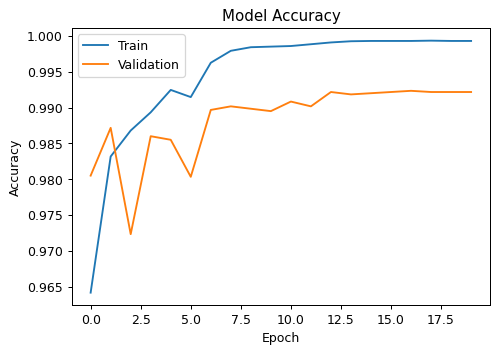

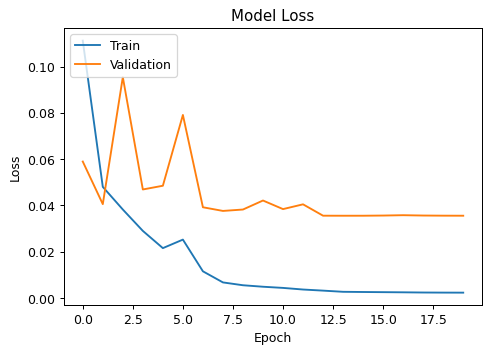

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=90)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 4), dpi=90)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 3. Resultados
Se creó otra funcionalidad para presentar los resultados probando aleatoriamente los conjuntos de datos

In [ ]:
def showtestmodel(model,ds,classnames=['none','none','none','none','none'],n=6):

  plt.figure(figsize=(9, int(5*np.ceil(n/3))), dpi=90)

  for images, labels in ds.take(1):
    print('\tpred','\t','real')
    for var in range(n):
      ax = plt.subplot(int(np.ceil(n/3)),3, var + 1)
      prediction = model.predict(images[var].numpy().astype("uint8").reshape(-1, img_height, img_width, 3))
      pred =np.round(prediction[0]).astype("int32")
      real= labels[var].numpy().astype("int32")
      check,col = ['\u2713','blue'] if cname(pred,classnames)==cname(real,classnames) else ['\u2717','red']
      print('[',var+1,']',pred,real,check)
      plt.imshow(images[var].numpy().astype("uint8"))
      try:
        plt.title('P:'+cname(pred,classnames)+' | R:'+cname(real,classnames),color=col)
      except:
        plt.title('prediccion',color=col)
        print(prediction[0])
      plt.axis("off")


Probar el modelo a partir del conjunto de datos de entrenamiento.

	pred 	 real
1/1 [==============================] - 2s 2s/step
[ 1 ] [1 0 0 0 0 0] [1 0 0 0 0 0] ✓
1/1 [==============================] - 0s 40ms/step
[ 2 ] [1 0 0 0 0 0] [1 0 0 0 0 0] ✓
1/1 [==============================] - 0s 34ms/step
[ 3 ] [1 0 0 0 0 0] [1 0 0 0 0 0] ✓
1/1 [==============================] - 0s 33ms/step
[ 4 ] [0 1 0 0 0 0] [0 1 0 0 0 0] ✓
1/1 [==============================] - 0s 32ms/step
[ 5 ] [0 0 1 0 0 0] [0 0 1 0 0 0] ✓
1/1 [==============================] - 0s 33ms/step
[ 6 ] [0 1 0 0 0 0] [0 1 0 0 0 0] ✓


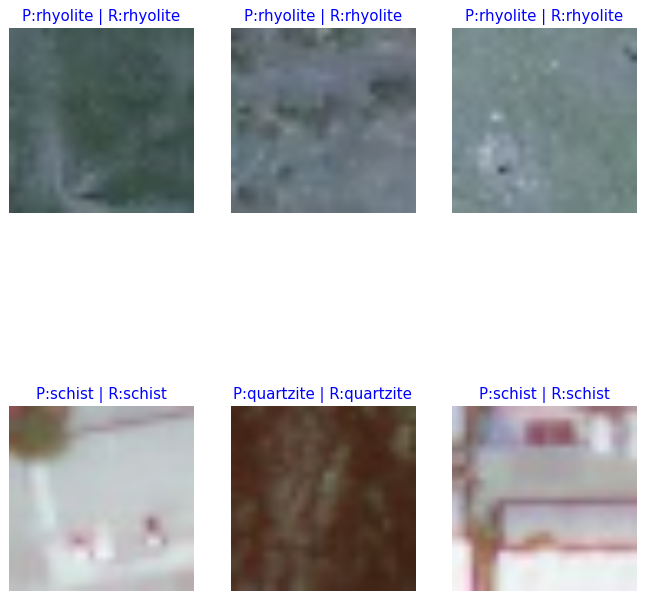

In [ ]:
showtestmodel(model,train_ds,classnames)


Probar el modelo a partir del conjunto de datos de Validación.


	pred 	 real
1/1 [==============================] - 0s 36ms/step
[ 1 ] [0 0 0 1 0 0] [0 0 0 1 0 0] ✓
1/1 [==============================] - 0s 33ms/step
[ 2 ] [1 0 0 0 0 0] [1 0 0 0 0 0] ✓
1/1 [==============================] - 0s 43ms/step
[ 3 ] [0 0 0 0 1 0] [0 0 0 0 1 0] ✓
1/1 [==============================] - 0s 40ms/step
[ 4 ] [0 0 1 0 0 0] [0 0 1 0 0 0] ✓
1/1 [==============================] - 0s 44ms/step
[ 5 ] [0 0 1 0 0 0] [0 0 1 0 0 0] ✓
1/1 [==============================] - 0s 27ms/step
[ 6 ] [1 0 0 0 0 0] [1 0 0 0 0 0] ✓


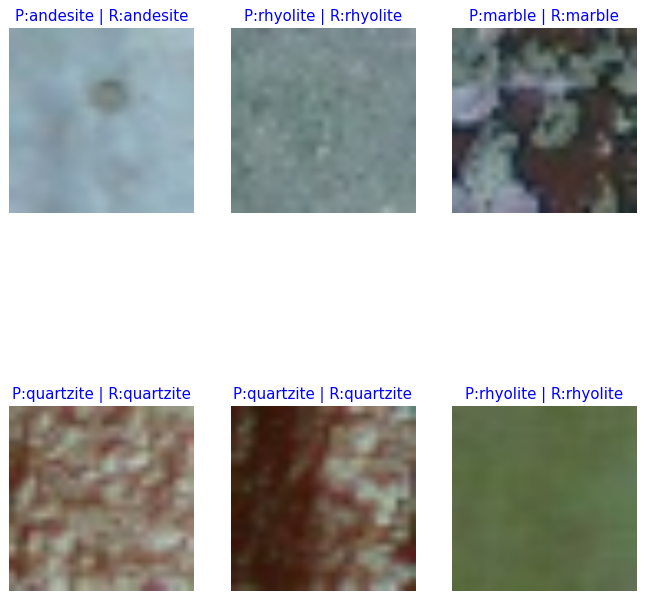

In [ ]:
showtestmodel(model,validation_ds,classnames,n=6)


La figura de la matriz de confusión se creó para evaluar el modelo. Muestra cómo el modelo clasificó cada clase.

Podemos ver que la mayoría de las muestras fueron clasificadas correctamente, a excepción de algunas muestras de esquistos y gneis que fueron clasificadas como andesita (38 y 11 muestras respectivamente), y algunas muestras de andesita que fueron clasificadas como esquisto (17 muestras).

A partir de la matriz de confusión, podemos calcular métricas de rendimiento como precisión, recuperación y puntuación F1 para evaluar el rendimiento general del modelo. Al calcular estas métricas encontramos un valor igual de 0,978 para todas, lo que representa que más del 97% de las muestras en el conjunto de datos de validación fueron clasificadas correctamente por el modelo propuesto.

In [ ]:
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
import seaborn as sns

def classification(y,classnames=classnames):
  classes =[]
  for i in range(y.shape[0]):
    classes.append(cname(y[i],classnames))
  return classes

val_X = []
real = []
for batch in validation_ds:
  val_X.append(batch[0])
  real.append(batch[1])

val_X = np.array(np.concatenate(val_X, axis=0))
realvalues = np.array(np.concatenate(real, axis=0))
prediction = model.predict(val_X)

pred=classification(prediction)
real=classification(realvalues)

In [ ]:
from mlxtend.evaluate import confusion_matrix
import seaborn as sns

confMatrix = confusion_matrix(pred, real,binary =False)
cM = pd.DataFrame(confMatrix, index=classnames, columns=classnames)
print('\tMatriz de Confusion\n',cM)

In [ ]:
plt.figure(figsize=(9, 6), dpi=90)
ax = plt.subplot()
sns.heatmap(confMatrix, annot=True, fmt=".0f")
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Matriz de Confusion')
ax.xaxis.set_ticklabels(classnames)
ax.yaxis.set_ticklabels(classnames)
plt.show()

Se calcularon las métricas.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf


accuracy = accuracy_score(real, pred)
precision = precision_score(real, pred, average='weighted')
recall = recall_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

# 4. Conclusiones
El modelo tiene un rendimiento general muy bueno: la precisión de 0,9922 indica que el modelo clasifica correctamente la mayoría de las muestras. A excepción de algunas muestras de andesita y cuarcita que fueron incorrectamente clasificadas.

De la matriz de confusión podemos concluir que algunas clases funcionan mejor que otras, como el mármol y el gneis, que tuvieron un desempeño excelente, clasificándose casi todas las muestras correctamente. Por otro lado, otras clases, como andesita y esquisto, tuvieron un desempeño ligeramente peor, con algunas muestras clasificadas incorrectamente, lo que puede llevarnos a la conclusión de que son clases muy similares, sin embargo, el alto valor de precisión sugiere que el modelo funciona. correctamente en la gran mayoría de los casos.

La técnica Transfer Learning es un método de aprendizaje automático que permite reutilizar modelos de redes neuronales previamente entrenados en otras tareas, con el objetivo de ahorrar tiempo y recursos en el proceso de entrenamiento. Al utilizar ResNet50 como una red neuronal previamente entrenada, el modelo puede aprovechar el conocimiento adquirido en el entrenamiento previo y ajustarlo para resolver problemas de clasificación específicos, como muestras geológicas.

Además, el uso de Transfer Learning permitió que el modelo redujera el consumo de recursos computacionales disponibles, haciéndolo más eficiente y accesible. Esto es particularmente importante en aplicaciones de aprendizaje automático que requieren una gran capacidad de procesamiento y almacenamiento, como es el caso de muchos modelos de visión por computadora.

En última instancia, la capacidad del modelo para clasificar con éxito muestras geológicas demuestra su relevancia y eficacia como herramienta poderosa en el mundo moderno. El uso de modelos de inteligencia artificial puede resultar beneficioso en varias áreas, incluido el análisis de imágenes, el diagnóstico médico y la previsión de tendencias del mercado, entre otras aplicaciones.